In [1]:
import multi_axis as ma
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy import constants                     # For scientific constants
%config Completer.use_jedi = False

Compilation successful


In [2]:
# load vortex cube from file
m = np.load('phantom/vortex_cube_L8.npy')

p1=(0.0, 0.0, 0.0)
p2=(1.25e-07, 1.25e-07, 1.25e-07)
n=(20, 20, 20)

mesh_params = [p1,p2,n]

MX = np.take(m,0,axis=3)
MY = np.take(m,1,axis=3)
MZ = np.take(m,2,axis=3)

In [3]:
def convertmag_T_Am(M_T):
    """ Enter 'equivalent' magnetisation in Tesla
    for a conversion to A/m.
    Can also input common materials as string, e.g. 
    'cobalt' """
    if M_T == 'cobalt':
        M_Am = 1435860
        
    else:
        M_Am = M_T / (4*np.pi*1e-7)
        
    return M_Am

class Magnetic_Phantom():
    """ Class for creating magnetic phantoms """

    def sphere(rad_m = 10*1e-9, Ms_Am = 797700, plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates uniformly magnetised sphere
            rad_m : Radius in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if (i-ci)**2 + (j-ci)**2 + (k-ci)**2 < (rad_m/res)**2:
                        MX[i,j,k] = np.cos(plan_rot*np.pi/180)*Ms_Am
                        MY[i,j,k] = np.sin(plan_rot*np.pi/180)*Ms_Am
        
        return MX,MY,MZ, mesh_params
    
    def rectangle(lx_m = 80*1e-9,ly_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates uniformly magnetised rectangle
            l_m = length of rectangle in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if ci-.5*lx_m/res < i < ci+.5*lx_m/res and \
                       ci-.5*ly_m/res < j < ci+.5*ly_m/res and \
                       ci-.5*lz_m/res < k < ci+.5*lz_m/res:
                        MX[i,j,k] = np.cos(plan_rot*np.pi/180)*Ms_Am
                        MY[i,j,k] = np.sin(plan_rot*np.pi/180)*Ms_Am
        
        return MX,MY,MZ, mesh_params
    
    def disc(rad_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates disk with c/w vortex magnetisation
            rad_m : Radius in metres
            lz_m = thickness of disc in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        def vortex(x,y):
            """ Returns mx/my components for vortex state, 
            given input x and y """
            # angle between tangent and horizontal
            theta=-1*np.arctan2(x,y)
            # cosine/sine components
            C=np.cos(theta)
            S = np.sin(theta)
            return C, S
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    if (i-ci)**2 + (j-ci)**2 < (rad_m/res)**2 and ci-.5*lz_m/res < k < ci+.5*lz_m/res:
                        mx,my = vortex(i-ci,j-ci)
                        MX[i,j,k] = mx*Ms_Am
                        MY[i,j,k] = my*Ms_Am
                        
        
        return MX,MY,MZ, mesh_params
    
    def tri_pris(rad_m = 30*1e-9, lz_m = 20*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates disk with c/w vortex magnetisation
            rad_m : Radius in metres
            lz_m = thickness of disc in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')
        
        # Define gradient/intercept of bounding lines
        m1, c1 = 5, 100
        m2, c2 = 0, -25
        m3, c3 = -0.6, 0

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    x = i-ci
                    y = j-ci
                    z = k-ci
                    if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and ((z >-20 and z<-10) or (z>0 and z<30)):
                        MX[i,j,k] = Ms_Am
                        
        #MX = np.swapaxes(MX,0,1)
                        
        return MX,MY,MZ, mesh_params
    
    def rod(rad_m = 10*1e-9, lx_m = 60*1e-9, Ms_Am = 797700, 
                  plan_rot=0, bbox_length_m = 100*1e-9, bbox_length_px = 100):
        """ Creates uniformly magnetised cylindrical rod lying along x
            rad_m : Radius in metres
            lx_m = length of rod in metres
            Ms_Am : Magnetisation in A/m
            plan_rot : Direction of magnetisation, rotated in degrees ac/w from +x
            bbox_length_m : Length in metres of one side of the bounding box
            bbox_length_px : Length in pixels of one side of the bounding box """
        
        # Initialise bounding box parameters
        p1 = (0,0,0)
        p2 = (bbox_length_m,bbox_length_m,bbox_length_m)
        n = (bbox_length_px,bbox_length_px,bbox_length_px)
        mesh_params = [p1,p2,n]
        res = bbox_length_m / bbox_length_px # resolution in m per px 
        ci = int(bbox_length_px/2) # index of bbox centre
        
        # Initialise magnetisation arrays
        mx = np.linspace(0,bbox_length_m,num=bbox_length_px) * 0
        my,mz = mx,mx
        MX, MY, MZ = np.meshgrid(mx, my, mz, indexing='ij')

        # Assign magnetisation
        for i,a in enumerate(MX):
            for j,b in enumerate(a):
                for k,c in enumerate(b):
                    x = i-ci
                    y = j-ci
                    z = k-ci
                    if (k-ci)**2 + (j-ci)**2 < (rad_m/res)**2 and ci-.5*lx_m/res < i < ci+.5*lx_m/res:
                        MX[i,j,k] = Ms_Am
                        
        #MX = np.swapaxes(MX,0,1)
                        
        return MX,MY,MZ, mesh_params

def plot_2d_mag(mx,my,mesh_params=None,Ms=None,s=1):
    """ Takes x/y magnetisation projections and creates a plot
        uses quivers for direction and colour for magnitude """
    if type(Ms) == type(None):
        Ms = np.max(np.max((mx**2+my**2)**.5))
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x = np.linspace(p1[0],p2[0],num=n[0])
    y = np.linspace(p1[1],p2[1],num=n[1])
    xs,ys = np.meshgrid(x,y)
    
    plt.quiver(xs[::s,::s],ys[::s,::s],mx[::s,::s].T,my[::s,::s].T,pivot='mid',scale=Ms*22,width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    mag = (mx**2+my**2)**.5
    plt.imshow(mag.T,origin='lower',extent=[p1[0],p2[0],p1[1],p2[1]],vmin=0,vmax=Ms,cmap='Blues')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('$|M_{\perp}$| / $A $', rotation=-270,fontsize=15)
    
    plt.xlabel('x / m',fontsize=15)
    plt.ylabel('y / m',fontsize=15)
    
def project_along_z(U,mesh_params=None):
    """ Takes a 3D array and projects along the z component 
    It does this by multiplying each layer by its thickness
    and then summing down the axis. """
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(U)
        p2 = (sx,sy,sz)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # Get resolution    
    z_size = p2[2]
    z_res = z_size/n[2]
    
    # project
    u_proj = np.sum(U*z_res,axis=2)
    
    return u_proj

def calculate_A_3D(MX,MY,MZ, mesh_params=None):
    """ Input(3D (nx,ny,nz) array for each component of M)
    """
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(MX)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # zero pad M to avoid FT convolution wrap-around artefacts
    n_pad = np.shape(MX)[0]
    mxpad = np.pad(MX,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mypad = np.pad(MY,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mzpad = np.pad(MZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take 3D FT of M    
    ft_mx = np.fft.fftn(mxpad)
    ft_my = np.fft.fftn(mypad)
    ft_mz = np.fft.fftn(mzpad)
    
    # Generate K values
    x_size = p2[0]
    x_res = x_size/n[0]

    kx = np.fft.fftfreq(ft_mx.shape[0],d=x_res)
    ky,kz = kx,kx
    KX, KY, KZ = np.meshgrid(kz,ky,kx, indexing='ij') # Create a grid of coordinates
    
    # vacuum permeability
    mu0 = 4*np.pi*1e-7
    
    # Calculate 1/k^2 with Tikhanov filter
    K2_inv = np.nan_to_num(((KX**2+KY**2+KZ**2)**.5)**-2)
#     k_filter = (1/x_size*x_res) * 0.01
#     K2_inv = ((KX**2+KY**2+KZ**2)**.5 + k_filter*.1)**-2
    
    # M x K
    cross_x = ft_my*KZ - ft_mz*KY
    cross_y = -ft_mx*KZ + ft_mz*KX
    cross_z = -ft_my*KX + ft_mx*KY
    
    # Calculate A(k)
    ft_Ax = (-1j * mu0 * K2_inv) * cross_x
    ft_Ay = (-1j * mu0 * K2_inv) * cross_y
    ft_Az = (-1j * mu0 * K2_inv) * cross_z
    
    # Inverse fourier transform
    Ax = np.fft.ifftn(ft_Ax)
    AX = Ax.real
    Ay = np.fft.ifftn(ft_Ay)
    AY = Ay.real
    Az = np.fft.ifftn(ft_Az)
    AZ = Az.real
    
    return AX[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AY[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AZ[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad]

def calculate_phase(AX,AY,AZ,angle=[0,0,0],mesh_params=None):
    """ Returns phase projection along z 
    for given A and angle """
    # Initialise parameters
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]

    if angle != [0,0,0]:
        ax,ay,az = angle
        #rotate A
        AX,AY,AZ = rotate_magnetisation(AX,AY,AZ,ax,ay,az)
    
    # project for AZ_proj
    AZ_proj = project_along_z(AZ,mesh_params=mesh_params)
    
    # Calculate phase
    phase = -1 * AZ_proj * np.pi/constants.codata.value('mag. flux quantum')

    return phase

def plot_phase_proj(phase,mesh_params=None):
    """ Plots the projected phase shift in rads """
    if mesh_params == None:
            p1 = (0,0,0)
            sx,sy,sz = np.shape(MX)
            p2 = (sx,sy,sx)
            n = p2
    else:
        p1,p2,n = mesh_params

    plt.imshow(phase.T,extent=[p1[0],p2[0],p1[1],p2[1]])
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Projected phase shift / rad', rotation=-270,fontsize=15)
    plt.xlabel('x / m',fontsize=14)
    plt.ylabel('y / m',fontsize=14)
    
def calculate_B_from_A(AX,AY,AZ,mesh_params=None):
    """ Returns phase projections for given A and angles"""
    # Initialise parameters
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    p1,p2,n = mesh_params
    res = p2[0]/n[0]
    
    # Take curl
    BX = np.gradient(AZ)[1] - np.gradient(AY)[2]
    BY = np.gradient(AX)[2] - np.gradient(AZ)[0]
    BZ = np.gradient(AY)[0] - np.gradient(AX)[1]
    
    # Convert units from 1/px to 1/m
    BX,BY,BZ = BX/res,BY/res,BZ/res
        
    return BX,BY,BZ

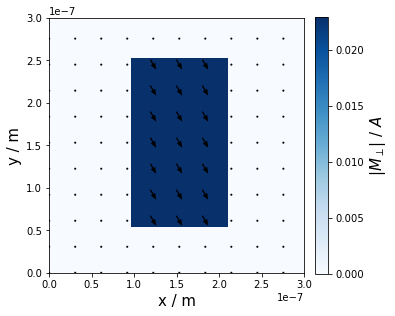

In [5]:
# Beleggia & Zhu
MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=120*1e-9,ly_m=200*1e-9,lz_m=20*1e-9,Ms_Am=convertmag_T_Am(1.6),
                                                plan_rot=300,bbox_length_m=300*1e-9,bbox_length_px=50) 

# Prabhat et al
#MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=50*1e-9,ly_m=50*1e-9,lz_m=30*1e-9,plan_rot=30,bbox_length_m=100*1e-9,bbox_length_px=50)

# Humphrey De Graef
#MX,MY,MZ,mesh_params=Magnetic_Phantom.sphere(rad_m=50*1e-9,bbox_length_px=75,Ms_Am=convertmag_T_Am(1/5),bbox_length_m=200*1e-9)

mx = project_along_z(MX,mesh_params=mesh_params)
my = project_along_z(MY,mesh_params=mesh_params)
plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)

In [6]:
AX,AY,AZ = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params)
phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in power


In [297]:
plt.imshow(AY[:,(50+22),:].T/(6*1e-9))
#plt.imshow(AX[:,:,(50+20)].T/(6*1e-9))
#plt.imshow(AY[:,(50+18),:].T/(6*1e-9))
plt.colorbar()

IndexError: index 72 is out of bounds for axis 1 with size 50

9.2542427569142411

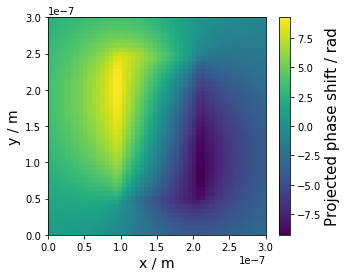

In [7]:
plot_phase_proj(phase,mesh_params=mesh_params)
np.max(phase)

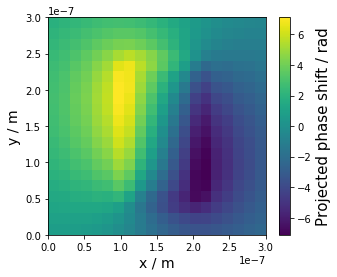

In [61]:
def calculate_phase_2(AX,AY,AZ, mesh_params=None):
    """ Alternative calculation of phase shift carried out in Fourier space """
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    res = p2[2]/n[2]
    n_pad=0
    AZpad = np.pad(AZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take 3D FT of AZ    
    ft_AZ = np.fft.fftn(AZpad)
    
    # take slice
    aslice =  ft_AZ[:,:,0]
    
    # Calculate phase(k)
    pk = aslice * -1 * np.pi/constants.codata.value('mag. flux quantum')
    
    # transform to real space
    pr = np.fft.ifft2(pk).real*res

    return pr

p2 = calculate_phase_2(AX,AY,AZ,mesh_params=mesh_params)
#plt.imshow(p2)
plot_phase_proj(p2,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in power


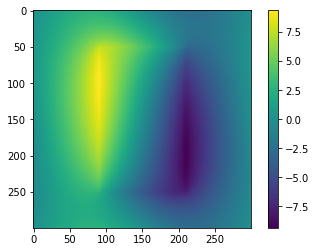

In [31]:
def analytical_rectangle(B0_T=1.6,lx_m=120*1e-9,ly_m=200*1e-9,lz_m=20*1e-9,mesh_params=None,beta=300):
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    p1,p2,n=mesh_params
    
    # Calculate prefactor
    V = lx_m*ly_m*lz_m
    const = 1j*np.pi*B0_T*V/constants.codata.value('mag. flux quantum')
    
    # Generate K values
    x_size = p2[0]
    x_res = x_size/n[0]
    #print(x_res)
    
    kx = np.fft.fftfreq(n[0],d=x_res)#/6) # WHY IS THERE A FACTOR OF 6 HERE?
    ky = kx
#     kx = np.fft.fftshift(kx)
#     ky = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx,ky)# indexing='ij') # Create a grid of coordinates
    
    
    
    # Calculate 1/k^2 with Tikhanov filter
    K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)

    #The normalized sinc function is the Fourier transform of the rectangular function with no scaling. np default is normalised
    phase_ft = const * K2_inv * (KY*np.cos(beta*np.pi/180) - KX*np.sin(beta*np.pi/180)) * np.sinc(lx_m*KX) * np.sinc(ly_m*KY) / x_res**2
    
    #print(n[0])
    
    phase = np.fft.ifft2(phase_ft).real 
    
    phase = np.fft.ifftshift(phase) 
    
    return phase
    
l=300
n=300
pa = analytical_rectangle(mesh_params=[(0,0,0),(l*1e-9,l*1e-9,l*1e-9),(n,n,n)])

plt.imshow(pa)#*(l/n)*1e9)
plt.colorbar()


In [136]:
ps = []
As = []
l = 300
for n in np.arange(100,500):
    pa = analytical_rectangle(mesh_params=[(0,0,0),(l*1e-9,l*1e-9,l*1e-9),(n,n,n)])
    p = np.max(pa)#*(l/n)*1e9
    ps.append(p)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Analytical')

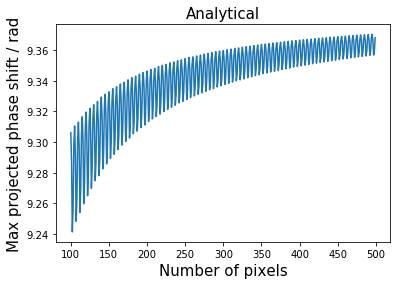

In [138]:
plt.plot(np.arange(100,500),ps)
plt.xlabel('Number of pixels',fontsize=15)
plt.ylabel('Max projected phase shift / rad',fontsize=15)
plt.title('Analytical',fontsize=15)

0.00099020323055479622

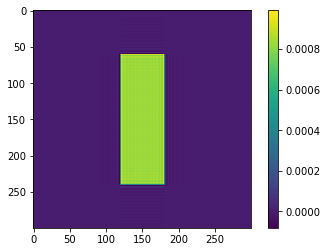

In [130]:
l = 100
n = 300
kx = np.fft.fftfreq(n) # WHY IS THERE A FACTOR OF 6 HERE?
ky = kx
KX, KY = np.meshgrid(kx,ky)
res = l/n
lx=20 / res
ly=60 / res
I_ft = np.sinc(lx*KX)*np.sinc(ly*KY) / res**2
I = np.fft.ifft2(I_ft).real
I = np.fft.fftshift(I)
plt.imshow(I)
plt.colorbar()
np.max(I)

In [9]:
ps = []
As = []
for n in np.arange(20,100):
    MX,MY,MZ,mesh_params=Magnetic_Phantom.rectangle(lx_m=120*1e-9,ly_m=200*1e-9,lz_m=20*1e-9,
                                                    Ms_Am=convertmag_T_Am(1.6),plan_rot=300,bbox_length_m=300*1e-9,bbox_length_px=n) 
    AX,AY,AZ = calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params)
    phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)
    p=np.max(phase)
    ps.append(p)
    a = np.max(AZ)
    As.append(a)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:289: RuntimeWarning: divide by zero encountered in power


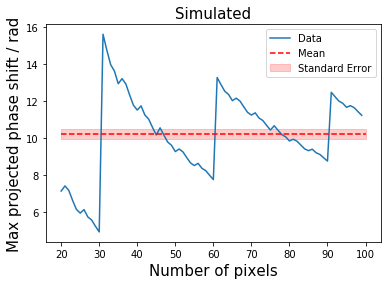

In [27]:
plt.plot(np.arange(20,100),ps,label='Data')
plt.xlabel('Number of pixels',fontsize=15)
plt.ylabel('Max projected phase shift / rad',fontsize=15)
plt.title('Simulated',fontsize=15)

from scipy.optimize import curve_fit

avg = np.mean(ps)
err = np.std(ps)/np.sqrt(np.shape(ps)[0])
plt.plot([20,100],[avg,avg],'r--',label='Mean')
plt.fill_between([20,100],[avg-err,avg-err],[avg+err,avg+err],color='r',alpha=.2,label='Standard Error')
plt.legend()

9.4475518138242975

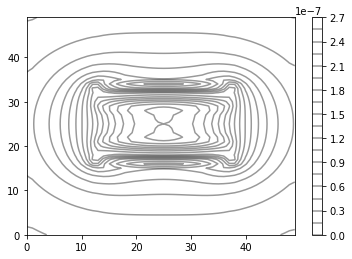

In [76]:
BX,BY,BZ = calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)


bx = project_along_z(BX,mesh_params=mesh_params)
by = project_along_z(BY,mesh_params=mesh_params)
mag=np.hypot(bx,by)
plt.contour(mag.T,levels=20, colors='k',alpha=.4)
#plt.quiver(bx.T,by.T)
plt.colorbar()
np.max(np.hypot(BX,BY,BZ))

In [81]:
ps = np.array(ps)
taus = np.array([1,2,5,10,100])
k = constants.codata.value('mag. flux quantum')#/(np.pi*(10*1e-9)**2*1.6)#*4*np.pi*1e-7)
k*1e18

2067.833831

In [271]:
ps = []
for r in [10,50,100,200]:
    #MX,MY,MZ,mesh_params=Magnetic_Phantom.rod(lx_m = 2*tau*1e-8, bbox_length_m=2*tau*1e-8*1.2,bbox_length_px=50)
    MX,MY,MZ,mesh_params=Magnetic_Phantom.disc(rad_m = r*1e-9, bbox_length_m=2.2*r*1e-9,bbox_length_px=50)
    mx = project_along_z(MX,mesh_params=mesh_params)
    my = project_along_z(MY,mesh_params=mesh_params)
    #plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
    AX,AY,AZ = A_calc_3D(MX,MY,MZ,mesh_params=mesh_params)
    phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)
    ps.append(np.max(phase))

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Vortex disk')

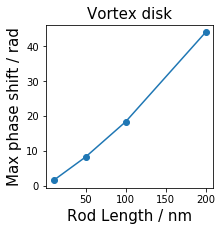

In [272]:
plt.figure(figsize=(3,3))
plt.plot([10,50,100,200],ps,'o-')
plt.xlabel('Rod Length / nm',fontsize=15)
plt.ylabel('Max phase shift / rad',fontsize=15)
plt.title('Vortex disk',fontsize=15)

In [270]:
ps

[36732790499962160.0,
 9.1831976249905446e+17,
 3.6732790499962179e+18,
 1.4693116199984871e+19]

In [7]:
# generate cobalt sphere 6 nm diam
size_n= 10*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(20, 20, 20)

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

#Mxx[4:16,4:16,4:16] = 1435860 # cobalt
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-10)**2 + (j-10)**2 + (k-10)**2 < 6**2:
                Mxx[i,j,k] = 1435860 * 1 # cobalt 


MX,MY,MZ = Mxx,Myy,Mzz



mesh_params = [p1,p2,n]

In [158]:
# generate cobalt sphere
size_n= 200*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(50, 50, 50)

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

#Mxx[4:16,4:16,4:16] = 1435860 # cobalt
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-25)**2 + (j-25)**2 + (k-25)**2 < 12.5**2: # 50 nm radius
                Mxx[i,j,k] = -1*np.sin(30*np.pi/180) * 1e4
                Myy[i,j,k] = np.cos(30*np.pi/180) * 1e4


MX,MY,MZ = Mxx,Myy,Mzz



mesh_params = [p1,p2,n]

In [204]:
# generate platonic sphere 1T, 50 nm rad
r = (10**6*3/4/np.pi)**(1/3) *1e-9 # 62 nm
Ms = 797700 #1T in A/m

size_n= 200*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(50, 50, 50)

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-25)**2 + (j-25)**2 + (k-25)**2 < (r*1e9/4)**2: # 50 nm radius
                Mxx[i,j,k] = -1*np.sin(0*np.pi/180) * Ms
                Myy[i,j,k] = np.cos(0*np.pi/180) * Ms


MX,MY,MZ = Mxx,Myy,Mzz



mesh_params = [p1,p2,n]
r*1e9/4

15.508762272484997

In [460]:
# rectangular nanoparticle

size_n= 300*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(100, 100, 100)
res = size_n/n[0]*1e9

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

#Mxx[4:16,4:16,4:16] = 1435860 # cobalt
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if 90 < i*res < 210 and 50 < j*res < 250 and 140 < k*res < 160:
                Mxx[i,j,k] = np.sin(300*np.pi/180) * 1276320 # 1.6 T
                Myy[i,j,k] = np.cos(300*np.pi/180) * 1276320
                
MX,MY,MZ = Mxx,Myy,Mzz
mesh_params = [p1,p2,n]

In [236]:
# rectangular nanoparticle

size_n= 100*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(100, 100, 100)
res = size_n/n[0]*1e9

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

#Mxx[4:16,4:16,4:16] = 1435860 # cobalt
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if 25 < i*res < 75 and 25< j*res < 75 and 35 < k*res < 65:
                Mxx[i,j,k] = np.cos(np.pi/6) * 797700
                Myy[i,j,k] = np.sin(np.pi/6) * 797700
                
MX2,MY2,MZ2 = Mxx,Myy,Mzz
mesh_params2 = [p1,p2,n]

In [237]:
MX[np.where(MX!=MX2)]

array([], dtype=float64)

In [453]:
# cylindrical nanoparticle
def vortex(x,y):
    """ Returns mx and my components for a ring with 
    vortex state magnetisation given input x and y
    values that lie inside the ring material"""
    
    # gradient of tangent
    #m = -x/y
    
    # angle between tangent and horizontal
    #theta = np.arctan(m)
    theta=-1*np.arctan2(y,x)
    C=np.cos(theta)
    S = np.sin(theta)
    # calculate relative cos/sin
        # for positive y
#     if y > 0:
#         C = np.cos(theta)
#         S = np.sin(theta)
    
#         # for y = 0
#     elif y == 0:
#         if x<0:
#             C = 0
#             S = 1
#         else:
#             C = 0
#             S = -1
            
#         # for negative y        
#     else:
#         C = -np.cos(theta)
#         S = -np.sin(theta)
    
    return C, S

size_n= 100*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(100, 100, 100)
res = size_n/n[0]*1e9

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')

#Mxx[4:16,4:16,4:16] = 1435860 # cobalt
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-50)**2 + (j-50)**2 < (30)**2 and 35<k*res<65:
                mx,my=vortex(i-50,j-50)
                Mxx[i,j,k] = -mx * 797700
                Myy[i,j,k] = -my * 797700
                
MX,MY,MZ = Mxx,Myy,Mzz
mesh_params = [p1,p2,n]

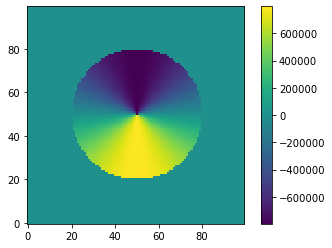

In [454]:
#plt.quiver(MX[::5,::5,50],MY[::5,::5,50])
plt.imshow(MX[:,:,50],origin='top')
plt.colorbar()

In [199]:
def rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = ndimage.rotate(P,ax,reshape=False,axes=(1,2),order=1)
    P = ndimage.rotate(P,ay,reshape=False,axes=(2,0),order=1)
    P = ndimage.rotate(P,az,reshape=False,axes=(0,1),order=1)

    return P


def grid_to_coor(U,V,W):
    """ Convert gridded 3D data (3,n,n,n) into coordinates (n^3, 3) """
    coor_flat = []
    nx = np.shape(U)[0]
    ny = np.shape(U)[1]
    nz = np.shape(U)[2]
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                x = U[ix,iy,iz]
                y = V[ix,iy,iz]
                z = W[ix,iy,iz]
                coor_flat.append([x,y,z])
                
    return coor_flat

def coor_to_grid(coor_flat,shape=None):
    """ Convert coordinates (n^3, 3) into gridded 3D data (3,n,n,n) """
    if shape == None:
        n = int(np.round(np.shape(coor_flat)[0]**(1/3)))
        shape = (n,n,n)
    nx,ny,nz = shape
    
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    U = x.reshape((nx,ny,nz))
    V = y.reshape((nx,ny,nz))
    W = z.reshape((nx,ny,nz))

    return U, V, W

def rotation_matrix(ax,ay,az):
    """ 
    Generate 3D rotation matrix from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """

    ax = ax * np.pi/180
    Cx = np.cos(ax)
    Sx = np.sin(ax)
    mrotx = np.array([[1,0,0],[0,Cx,-Sx],[0,Sx,Cx]])
    
    ay = ay * np.pi/180
    Cy = np.cos(ay)
    Sy = np.sin(ay)
    mroty = np.array([[Cy,0,Sy],[0,1,0],[-Sy,0,Cy]])
    
    az = az * np.pi/180
    Cz = np.cos(az)
    Sz = np.sin(az)
    mrotz = np.array([[Cz,-Sz,0],[Sz,Cz,0],[0,0,1]])
    
    mrot = mrotz.dot(mroty).dot(mrotx)
    
    return mrot

def rotate_vector(coor_flat,ax,ay,az):
    """ Rotates vectors by specified angles ax,ay,az 
    about the x,y,z axes (given in degrees) """
    
    # Get rotation matrix
    mrot = rotation_matrix(ax,ay,az)    

    coor_flat_r = np.zeros_like(coor_flat)
    
    # Apply rotation matrix to each M vector
    for i,M in enumerate(coor_flat):
        coor_flat_r[i] = mrot.dot(M)
    
    return coor_flat_r

def rotate_magnetisation(U,V,W,ax=0,ay=0,az=0):
    """ 
    Takes 3D gridded magnetisation values as input
    and returns them after an intrinsic rotation ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
    # Rotate the gridded locations of M values
    Ub = rotate_bulk(U,ax,ay,az)
    Vb = rotate_bulk(V,ax,ay,az)
    Wb = rotate_bulk(W,ax,ay,az)
    
    shape = np.shape(Ub)
    
    # Convert gridded values to vectors
    coor_flat = grid_to_coor(Ub,Vb,Wb)
    
    # Rotate vectors
    coor_flat_r = rotate_vector(coor_flat,ax,ay,az)
    
    # Convert vectors back to gridded values
    Ur,Vr,Wr = coor_to_grid(coor_flat_r,shape=shape)
    
    # Set small values to 0
    # (In theory the magnitude of M in each cell should be Ms,
    #  so we can set magnitude lower than this to zero -
    #  typically python rounding errors lead to very small values,
    #  which it is useful to exclude here)
    mag_max = (np.max(U)**2+np.max(V)**2+np.max(W)**2)**0.5
    mag = (Ur**2+Vr**2+Wr**2)**.5
#     for M in [Ur,Vr,Wr]:
#         M[abs(M)<1e-5*mag_max] = 0
#         M[mag<.6*mag_max] = 0
    
    return Ur,Vr,Wr

def project_along_z(U,V,W,mesh_params=None):
#     u_proj = np.mean(U,axis=2)
#     v_proj = np.mean(V,axis=2)
#     w_proj = np.mean(W,axis=2)

    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(U)
        p2 = (sx,sy,sz)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    z_size = p2[2]
    z_res = z_size/n[2]
    
    u_proj = np.sum(U*z_res,axis=2)
    v_proj = np.sum(V*z_res,axis=2)
    w_proj = np.sum(W*z_res,axis=2)
    
    return u_proj, v_proj, w_proj

def extract_z_slice(U,V,W, i_z_slice=None):
    # default to central slice
    if type(i_z_slice) == type(None):
        _,_,z_size = np.shape(W)
        i_z_slice = int(z_size/2)
        
    u_slice = U[:,:,i_z_slice]
    v_slice = V[:,:,i_z_slice]
    
    return u_slice,v_slice

def plot_2d_mag(mx,my,mesh_params=None,i_z_slice=None,Ms=None,s=1):
    if type(Ms) == type(None):
        Ms = np.max(np.max((mx**2+my**2)**.5))
    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    #ax.axis('equal')
    
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x = np.linspace(p1[0],p2[0],num=n[0])
    y = np.linspace(p1[1],p2[1],num=n[1])
    xs,ys = np.meshgrid(x,y)
    

    plt.quiver(xs[::s,::s],ys[::s,::s],mx[::s,::s].T,my[::s,::s].T,pivot='mid',scale=Ms*22,width=0.009,headaxislength=5,headwidth=4,minshaft=1.8)
    mag = (mx**2+my**2)**.5
    plt.imshow(mag.T,origin='lower',extent=[p1[0],p2[0],p1[1],p2[1]],vmin=0,vmax=Ms,cmap='Blues')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('$|M_{\perp}$| / $A $', rotation=-270,fontsize=15)
    
    plt.xlabel('x / m',fontsize=15)
    plt.ylabel('y / m',fontsize=15)


def A_calc_2(mx,my,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # pad M to avoid artefacts
    n_pad = np.shape(mx)[0]
    mxpad = np.pad(mx,[(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mypad = np.pad(my,[(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take FT of M_proj
    # M_proj has units of (A/m) * m
    # i.e. integrated along z
    # i.e. each m corresponds to z_res thickness
    z_size = p2[2]
    z_res = z_size/n[2]
    
    ft_mx = np.fft.fft2(mxpad)
    ft_my = np.fft.fft2(mypad)
    
    # Generate K values
    x_size = p2[0]
    x_res = x_size/n[0]

    kx = np.fft.fftfreq(ft_mx.shape[0],d=x_res)
    ky = kx
    KX, KY = np.meshgrid(ky,kx, indexing='ij') # Create a grid of coordinates
    
    # vacuum permeability
    mu0 = 4*np.pi*1e-7
    
    # 1/k^2 
    K2_inv = np.nan_to_num(((KX**2+KY**2)**.5)**-2)
    #k_filter = (1/x_size*x_res) * 0.01
    #K2_inv = ((KX**2+KY**2)**.5 + k_filter*.1)**-2
    #K2_inv = ((KX**2)+(KY**2)) / ((KX**2)+(KY**2)+k_filter**2)**2
    #print(x_size)
    
    # M x K
    cross_z = -ft_my*KX + ft_mx*KY
    
    # Calculate A(k)
    ft_Az = (-1j * mu0 * K2_inv) * cross_z
    
    # Calculate A(x,y)
    Az = np.fft.ifft2(ft_Az)
    Az = Az.real
    return Az[n_pad:-n_pad,n_pad:-n_pad]

def generate_phase_data(MX,MY,MZ,angles,mesh_params=None):
    """ Returns phase projections for given M and angles
    in order [x, i_tilt, y] """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    # Loop through projection angles
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        #rotate M
        MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
        # calculate A
        AX,AY,AZ = A_calc_3D(MXr,MYr,MZr,mesh_params=mesh_params)
        
        # calculate phase projection
        phase = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)

        phase_projs.append(phase)            
    
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
    phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column
        
    return np.array(phase_projs)

def plot_rafal(b_field_x,b_field_y,mag_B,ax1=None,mesh_params=None):
    if ax1 == None:
        plt.figure()
        ax1 = plt.gca()
    skip_arrow = 5
    size_arrow = 0.25
    angle = 0
    
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(b_field_x)
        p2 = (s[0],s[1],s[0])
        n = p2
        
    x_begin,x_end = p1[0],p2[0]
    y_begin,y_end = p1[1],p2[1]
    
    # cmap
    import matplotlib.colors
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as patches
    cvals  = [-2., 2]
    colors = ["black","black"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[int(0.15*cmap.N):int(0.95*cmap.N),-1] = np.linspace(1, 0, 0.8*cmap.N+1)
    my_cmap[int(0.95*cmap.N):,-1] = np.ones_like(my_cmap[int(0.95*cmap.N):,-1])*0
    # Create new colormap
    my_cmap = ListedColormap(my_cmap)

    # plot B field direction as a colour
    ax1.imshow(ndimage.rotate(np.arctan2(b_field_y,b_field_x).T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end], cmap='hsv')

    # Plot magnitude of B as in black/transparent scale
    ax1.imshow(ndimage.rotate(mag_B.T,-90),origin='lower', 
               extent=[x_begin, x_end, y_begin,y_end],interpolation='spline16', cmap=my_cmap)

    #ax1.set_title(r'$\bf{B}$$_\perp$', fontsize=25)
    ax1.set_xlabel('x', fontsize = 16)
    ax1.set_ylabel('y', fontsize = 16)



    ax1.axis('off')

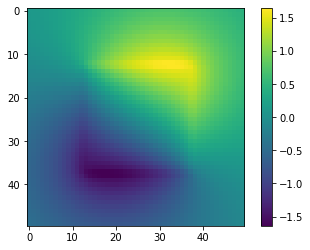

In [200]:
def calculate_phase(AX,AY,AZ,angle=[0,0,0],mesh_params=None):
    """ Returns phase projection along z 
    for given A and angle """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]

    if angle != [0,0,0]:
        ax,ay,az = angle
        #rotate A
        AX,AY,AZ = rotate_magnetisation(AX,AY,AZ,ax,ay,az)
    
    # project for AZ_proj
    _,_,AZ_proj = project_along_z(AX,AY,AZ,mesh_params=mesh_params)
    phase = AZ_proj * np.pi/constants.codata.value('mag. flux quantum')

    return phase

p1 = calculate_phase(AX,AY,AZ,mesh_params=mesh_params)
plt.imshow(p1)
plt.colorbar()

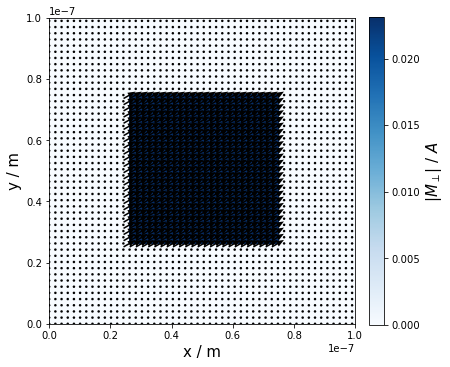

In [201]:
MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,0,0,0)
mx,my,_ = project_along_z(MXr,MYr,MZr,mesh_params=mesh_params)
plot_2d_mag(mx,my,mesh_params=mesh_params,s=2)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in power


Text(0, 0.5, 'y / m')

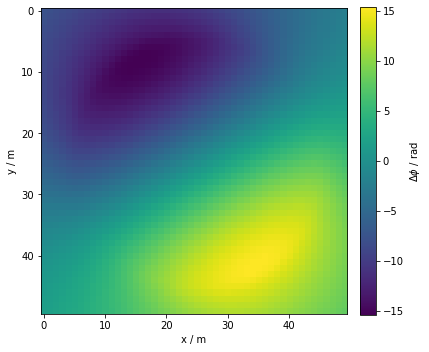

In [100]:
A = A_calc_2(mx,my,mesh_params=mesh_params)
phase = A * np.pi/constants.codata.value('mag. flux quantum')



fig = plt.figure(figsize=(6, 6))
plt.imshow(phase)
#plt.imshow(phase,extent=[p1[0],p2[0],p1[1],p2[1]],cmap='gray')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('$\Delta \phi$ / rad ', rotation=-270)
plt.xlabel('x / m')
plt.ylabel('y / m')

Text(0.5, 1.0, 'Projected phase shift / rad')

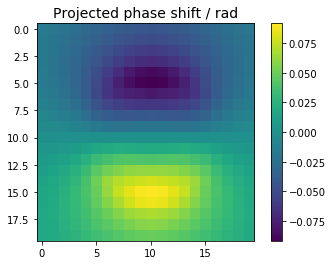

In [8]:
t,_,_ = project_along_z(AZ,AZ,AZ,mesh_params=mesh_params)
plt.imshow(t.T* np.pi/constants.codata.value('mag. flux quantum'))
plt.colorbar()
plt.title('Projected phase shift / rad',fontsize=14)

In [226]:
angles = ma.generate_angles(mode='x',alpha=70,n_tilt=5)

In [232]:
M_projs = generate_proj_data_mag(MX,MY,MZ,angles)

In [458]:
plot_2d_mag(M_projs[4,0],M_projs[4,1])

NameError: name 'M_projs' is not defined

C:\Users\grl31\miniconda3\envs\astraenv\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in power


-12.23775027205738 0.1836256631317628


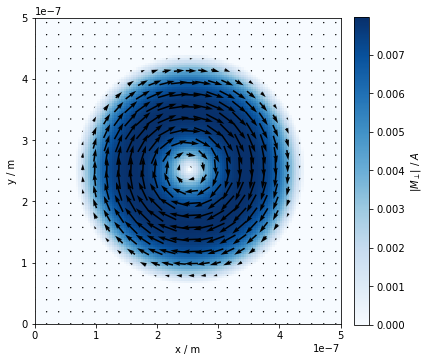

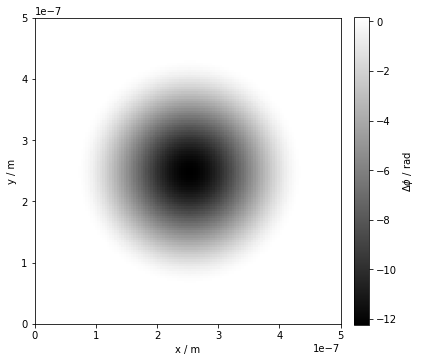

In [220]:
fpath1 = r'C:\Users\grl31\Downloads\PyLorentz-master\PyLorentz-master\SimLTEM'
fpath2= r'C:\Users\grl31\Downloads\PyLorentz-master\PyLorentz-master\PyTIE'
sys.path.append(fpath1)
sys.path.append(fpath2)
from TIE_helper import show_im, show_2D
from sim_helper import *

dim = 128
del_px = 500/dim # nm/pixel
zscale = 10 # nm/pixel in the z-direction
b0 = 1e4 # Gauss 
V0 = 10 # V
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)

MX=Bloch_x.reshape(dim,dim,1)*797700
MY=Bloch_y.reshape(dim,dim,1)*797700
MZ=Bloch_z.reshape(dim,dim,1)*797700

p1 = (0,0,0)
p2 = (500*1e-9,500*1e-9,10*1e-9)
n = (128,128,1)
mesh_params = [p1,p2,n]

MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,0,0,0)
mx,my,_ = project_along_z(MYr,MXr,MZr,mesh_params=mesh_params)
plot_2d_mag(my,mx,mesh_params=mesh_params,s=5)
np.shape(MX[:,:,0])

A = A_calc_2(-mx,-my,mesh_params=mesh_params)# * -1 * np.pi/constants.codata.value('mag. flux quantum')#*(constants.nano)**1
phase = A * np.pi/constants.codata.value('mag. flux quantum')

fig = plt.figure(figsize=(6, 6))
plt.imshow(phase,extent=[p1[0],p2[0],p1[1],p2[1]],cmap='gray')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('$\Delta \phi$ / rad ', rotation=-270)
plt.xlabel('x / m')
plt.ylabel('y / m')

print(np.min(phase),np.max(phase))

In [77]:
def calculate_B(phase_B,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    d_phase = np.gradient(phase_B)
    b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
    b_field_x = -b_const*d_phase[0]#/y_res
    b_field_y = b_const*d_phase[1]#/x_res

    mag_B = np.hypot(b_field_x,b_field_y)
    
    return mag_B,b_field_x,b_field_y



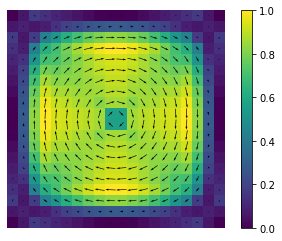

In [78]:
mag_B,b_field_x,b_field_y = calculate_B(phase,mesh_params=mesh_params)
plt.imshow(mag_B,origin='lower')
plt.quiver(b_field_x,b_field_y,pivot='mid')
plt.axis('off')
plt.colorbar()

6.9494674141620106e-15

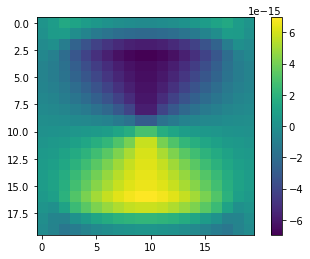

In [79]:
plt.imshow(b_field_x)
plt.colorbar()
np.max(b_field_x)

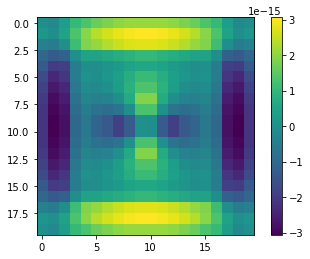

In [85]:
bz = -1*(np.gradient(b_field_x)[0]+np.gradient(b_field_y)[1])
plt.imshow(bz)
plt.colorbar()

In [22]:
plot_rafal(b_field_x,b_field_y,mag_B)

NameError: name 'plot_rafal' is not defined

## Reconstruction

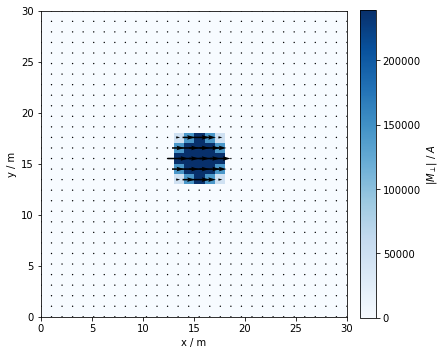

In [23]:
# Load micromagnetic input model
# generate cobalt sphere 6 nm diam
size_n= 30*1e-9
p1=(0.0, 0.0, 0.0)
p2=(size_n,size_n,size_n)
n=(30, 30, 30)

xs = np.linspace(0,size_n,num=n[0])
ys = np.linspace(0,size_n,num=n[0])
zs = np.linspace(0,size_n,num=n[0])

Mx = np.zeros_like(xs)
My = np.zeros_like(ys)
Mz = np.zeros_like(zs)

Mxx, Myy, Mzz = np.meshgrid(Mx, My, Mz, indexing='ij')
for i,a in enumerate(Mxx):
    for j,b in enumerate(a):
        for k,c in enumerate(b):
            if (i-15)**2 + (j-15)**2 + (k-15)**2 < 3**2:
                Mxx[i,j,k] = 1435860 * 1 # cobalt 
MX,MY,MZ = Mxx,Myy,Mzz
mesh_params = [p1,p2,n]

plot_2d_mag(np.mean(MX,axis=2).T,np.mean(MY,axis=2).T)

In [202]:
# calculate B from M
def calculate_B_from_A(AX,AY,AZ,mesh_params=None):
    """ Returns phase projections for given M and angles"""
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(AX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    BX = np.gradient(AZ)[1] - np.gradient(AY)[2]
    BY = np.gradient(AX)[2] - np.gradient(AZ)[0]
    BZ = np.gradient(AY)[0] - np.gradient(AX)[1]
        
    return BX,BY,BZ

def A_calc_3D(MX,MY,MZ, mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy,sz = np.shape(MX)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
    
    # pad M to avoid artefacts
    n_pad = np.shape(MX)[0]
    mxpad = np.pad(MX,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mypad = np.pad(MY,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)
    mzpad = np.pad(MZ,[(n_pad,n_pad),(n_pad,n_pad),(n_pad,n_pad)], mode='constant', constant_values=0)

    # take FT of M_proj
    # M_proj has units of (A/m) * m
    # i.e. integrated along z
    # i.e. each m corresponds to z_res thickness
    #z_size = p2[2]
    #z_res = z_size/n[2]
    
    ft_mx = np.fft.fftn(mxpad)
    ft_my = np.fft.fftn(mypad)
    ft_mz = np.fft.fftn(mzpad)
    
    # Generate K values
    x_size = p2[0]
    x_res = x_size/n[0]

    kx = np.fft.fftfreq(ft_mx.shape[0],d=x_res)
    ky,kz = kx,kx
    KX, KY, KZ = np.meshgrid(kz,ky,kx, indexing='ij') # Create a grid of coordinates
    
    # vacuum permeability
    mu0 = 4*np.pi*1e-7
    
    # 1/k^2 
    K2_inv = np.nan_to_num(((KX**2+KY**2+KZ**2)**.5)**-2)
    #k_filter = (1/x_size*x_res) * 0.01
    #K2_inv = ((KX**2+KY**2)**.5 + k_filter*.1)**-2
    #K2_inv = ((KX**2)+(KY**2)) / ((KX**2)+(KY**2)+k_filter**2)**2
    #print(x_size)
    
    # M x K
    cross_x = ft_my*KZ - ft_mz*KY
    cross_y = -ft_mx*KZ + ft_mz*KX
    cross_z = -ft_my*KX + ft_mx*KY
    
    # Calculate A(k)
    ft_Ax = (-1j * mu0 * K2_inv) * cross_x
    ft_Ay = (-1j * mu0 * K2_inv) * cross_y
    ft_Az = (-1j * mu0 * K2_inv) * cross_z
    
    # Calculate A(x,y)
    Ax = np.fft.ifftn(ft_Ax)
    AX = Ax.real
    Ay = np.fft.ifftn(ft_Ay)
    AY = Ay.real
    Az = np.fft.ifftn(ft_Az)
    AZ = Az.real
    return AX[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AY[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad],AZ[n_pad:-n_pad,n_pad:-n_pad,n_pad:-n_pad]

AX,AY,AZ = A_calc_3D(MX,MY,MZ,mesh_params=mesh_params)
BX,BY,BZ = calculate_B_from_A(AX,AY,AZ ,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


Text(0.5, 1.0, 'Ay [x, 50+15, z] / T $\\bullet$ (6 nm)')

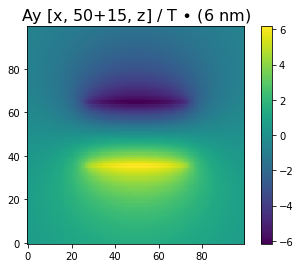

In [204]:
#plt.imshow(np.flipud(AY[:,65,:].T))
plt.imshow(AY[:,(50+18),:].T/(6*1e-9),origin='top')
plt.colorbar()
plt.title(r'Ay [x, 50+15, z] / T $\bullet$ (6 nm)',fontsize=16)

In [31]:
# Generate phase projection data
angles_x = ma.generate_angles(mode='x',n_tilt=10)
angles_y = ma.generate_angles(mode='y',n_tilt=10)
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params)

/home/grl31/anaconda3/envs/astraenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in power


In [39]:
# reconstruction 
vectors_x = ma.generate_vectors(angles_x)
recon = ma.generate_reconstruction(phases_x,vectors_x,algorithm='SIRT3D_CUDA',niter=30,callback_freq=5,weight=0.001)
recon_x = ma.reorient_reconstruction(recon)

vectors_y = ma.generate_vectors(angles_y)
recon = ma.generate_reconstruction(phases_y,vectors_y,algorithm='SIRT3D_CUDA',niter=30,callback_freq=5,weight=0.001)
recon_y = ma.reorient_reconstruction(recon)

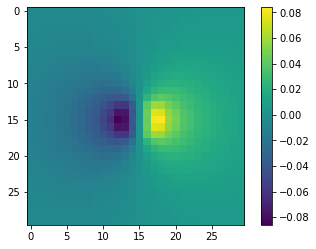

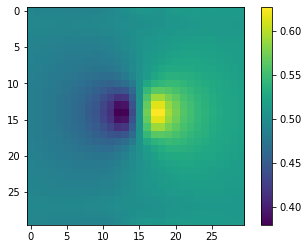

In [42]:
plt.imshow(phases_x[:,5,:])
plt.colorbar()
plt.show()
plt.imshow(np.mean(recon_x,axis=2).T)
plt.colorbar()

In [9]:
import tomopy

In [17]:
# basic reconstruction
theta = np.take(angles_x,0,axis=1) * np.pi/180
recon = tomopy.recon(phases_x, theta, algorithm='sirt',num_iter = 20)
recon = np.transpose(recon,axes=(0,2,1))
recon = recon[:,::-1,::-1]
recon_x = recon

recon = tomopy.recon(phases_y, theta, algorithm='sirt',num_iter = 20)
recon = np.transpose(recon,axes=(0,2,1))
recon = recon[:,::-1,::-1]
recon_y = recon

In [45]:
BXr,BYr,BZr = calculate_B_dual(recon_x,recon_y,mesh_params=mesh_params)

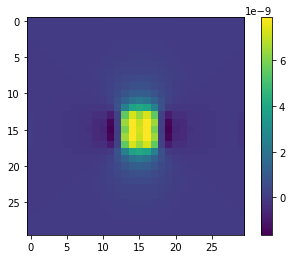

In [55]:
plt.imshow(BX[:,:,15])
plt.colorbar()

Text(0.5, 1.0, 'B[x,y,-1 nm]')

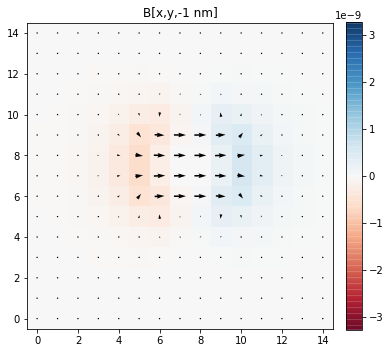

In [68]:
def plot_B(BX,BY,BZ,i_slice):
    plt.figure(figsize=(6,6))
    mag = (BX**2+BY**2+BZ**2)**.5
    mmax = np.max(mag)
    bx = BX[::2,::2,i_slice]
    by = BY[::2,::2,i_slice]
    bz = BZ[::2,::2,i_slice]
    plt.quiver(bx.T,by.T,pivot='mid',width=.005,scale=2e-7) # 60
    plt.imshow(bz.T,origin='top',cmap='RdBu',alpha=.8,vmin=-mmax*.4,vmax=mmax*.4)
    plt.colorbar(fraction=0.046, pad=0.04)
    
plot_B(BX,BY,BZ,16)
plt.title('B[x,y,-1 nm]')

In [44]:
def calculate_B_dual(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    for i in range(np.shape(PX)[2]):
        px = PX[:,:,i]
        py = PY[:,:,i]
        d_phase_x = np.gradient(px)
        d_phase_y = np.gradient(py)
        b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
        b_field_x = -b_const*d_phase_x[0]#/y_res
        b_field_y = b_const*d_phase_y[1]#/x_res
        b_field_z = -1*(np.gradient(b_field_x)[0]+np.gradient(b_field_y)[1])
        
        BX.append(b_field_x)
        BY.append(b_field_y)
        BZ.append(b_field_z)
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [ ]:
# intensity 
# beyond x/y

Text(0.5, 1.0, 'B(x,y,-1 nm)')

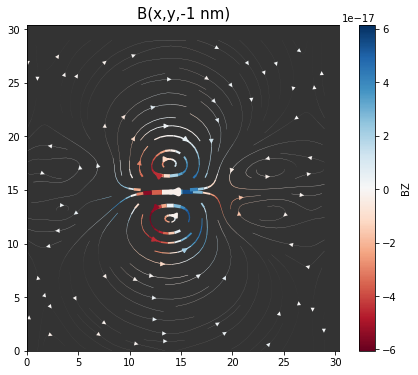

In [68]:
x=np.arange(30)
plt.figure(figsize=(7,6))
i=14
mag = (BXr.T[:,:,i].T**2 + BXr[:,:,i].T**2)**.5
col = BZr.T[:,:,i].T
lw = 5*mag/np.max(mag)
plt.streamplot(x,x,BXr.T[:,:,i].T,BYr.T[:,:,i].T,density=1,color=np.fliplr(col.T),linewidth=lw,cmap='RdBu')
ax = plt.gca()
ax.set_facecolor((0,0,0,.8))
cbar = plt.colorbar()
cbar.ax.set_ylabel('BZ')
plt.title('B(x,y,-1 nm)',fontsize=15)

In [71]:
xx=np.arange(30)

In [69]:
import chart_studio.plotly as py
import plotly.graph_objs as go

In [72]:
x,y,z = np.meshgrid(xx,xx,xx)
u,v,w = BX,BY,BZ

In [73]:
pl_curl=[[0.0, 'rgb(20, 29, 67)'],# curl is a cmocean colormap 
         [0.05, 'rgb(25, 52, 80)'],
         [0.1, 'rgb(28, 76, 96)'],
         [0.15, 'rgb(23, 100, 110)'],
         [0.2, 'rgb(16, 125, 121)'],
         [0.25, 'rgb(44, 148, 127)'],
         [0.3, 'rgb(92, 166, 133)'],
         [0.35, 'rgb(140, 184, 150)'],
         [0.4, 'rgb(182, 202, 175)'],
         [0.45, 'rgb(220, 223, 208)'],
         [0.5, 'rgb(253, 245, 243)'],
         [0.55, 'rgb(240, 215, 203)'],
         [0.6, 'rgb(230, 183, 162)'],
         [0.65, 'rgb(221, 150, 127)'],
         [0.7, 'rgb(211, 118, 105)'],
         [0.75, 'rgb(194, 88, 96)'],
         [0.8, 'rgb(174, 63, 95)'],
         [0.85, 'rgb(147, 41, 96)'],
         [0.9, 'rgb(116, 25, 93)'],
         [0.95, 'rgb(82, 18, 77)'],
         [1.0, 'rgb(51, 13, 53)']]

In [74]:
cones = dict(type='cone',
              x=x.flatten(),
              y=y.flatten(), 
              z=z.flatten(), 
              u=u.flatten(), 
              v=v.flatten(), 
              w=w.flatten(), 
              sizemode='scaled',
              sizeref=2,
              showscale=True,
              colorscale=pl_curl, 
              colorbar=dict(thickness=20, ticklen=4, len=0.75), 
              anchor='tail'
          )

In [75]:
def get_layout(title='Cone  Plot', width=800, height=750, aspect=[1, 1, 0.9]):
    axis = dict(showbackground=True, 
                backgroundcolor="rgb(235, 235,235)",
                gridcolor="rgb(255, 255, 255)",      
                zerolinecolor="rgb(255, 255, 255)",
                )

    return   dict(title=title, 
                  width=width,
                  height=height,
                  autosize=False,
                  scene=dict(camera=dict(eye=dict(x=1.15, y=1.15, z=0.6)),
                             xaxis=dict(axis),
                             yaxis=dict(axis), 
                             zaxis=dict(axis),
                             aspectratio=dict(x=aspect[0],
                                              y=aspect[1],
                                              z=aspect[2]))
              )

In [81]:
fig1 = go.Figure(data=[cones], 
            layout=get_layout(title='The cone plot of the ABC-flow',
                              width=650,
                              height=600
                                            ))
#py.iplot(fig1, filename='cones-ABC', validate=False)
fig1.show()

In [90]:
step=1
id_z=16
z_slice=step*id_z
str_z_slice=str(round(z_slice, 2))# the string version of the zslice to be displayed in the plot title

slice_z_cones=dict(type='cone',
                   x=x[:, :, id_z].flatten(),
                   y=y[:, :, id_z].flatten(),
                   z=z[:, :, id_z].flatten(),
                   u=u[:, :, id_z].T.flatten(), 
                   v=v[:, :, id_z].T.flatten(), 
                   w=w[:, :, id_z].T.flatten(), 
                   sizemode='scaled',
                   sizeref=4,
                   showscale=True,
                   colorscale=pl_curl, 
                   colorbar=dict(thickness=20, ticklen=4, len=0.75), 
                   anchor='tail'
                )

In [91]:
layoutz=get_layout(title=f'Cone plot in the slice z={str_z_slice}',)
                   #width=700, height=650)
fig2=go.Figure(data=[slice_z_cones], layout=layoutz)
#fig2.layout.scene.zaxis.update(range=[0, 2*np.pi])

import plotly.io as pio
pio.renderers.default = 'iframe' 

#py.iplot(fig2, filename='cones-slicez')
fig2.show()